<a href="https://colab.research.google.com/github/delhian/NIR/blob/main/absolute_orientation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Absolute Orientation for Word Embedding Alignment
# https://www.cs.utah.edu/docs/techreports/2017/pdf/UUCS-17-003.pdf
# https://arxiv.org/pdf/1806.01330.pdf

In [ ]:
!pip install umap-learn > /dev/null
!pip install transformers > /dev/null

In [ ]:
import re
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import random
import umap.umap_ as umap
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
# from bokeh.models import ColumnDataSource, LabelSet, Legend, HoverTool, WheelZoomTool
from bokeh.models import ColumnDataSource, LabelSet, LegendItem, Legend, HoverTool, WheelZoomTool, PanTool, BoxZoomTool, ResetTool, TapTool, SaveTool
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook, show
output_notebook()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
import time
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import pairwise_distances
from random import choice
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
model_name ='bert-base-cased'
model_en = AutoModel.from_pretrained(model_name)
tokenizer_en = AutoTokenizer.from_pretrained(model_name)
# name = '/content/drive/MyDrive/Anthony & Margroff - K1 - Dragon\'s Gold.txt'
name = './Stephen King - Needful Things.txt'
with open(name, 'r',) as file:
    text_en = file.read()
print(len(text_en))

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

1382371


In [ ]:
# model_name ='DeepPavlov/rubert-base-cased-sentence/
model_name ='DeepPavlov/rubert-base-cased'
tokenizer_ru = AutoTokenizer.from_pretrained(model_name)
model_ru = AutoModel.from_pretrained(model_name)

name_ru_kurl = './Нужные вещи_Курляндская.txt'
with open(name_ru_kurl, 'r', encoding='windows-1251') as file:
    text_ru_kurl = file.read()
print(len(text_ru_kurl))

name_ru_sarn = './Нужные вещи_Сарнов.txt'
with open(name_ru_sarn, 'r', ) as file:
    text_ru_sarn = file.read()
print(len(text_ru_sarn))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1423133
1400576


In [ ]:
phrases_ru = pd.DataFrame([['бел', 'white'], 
                           ['черн', 'black'],
                           ['красн', 'red'],
                           ['желт', 'yellow'],
                           ['зелен', 'green'],
                           ['голуб', 'blue'],
                           ['син', 'blue'], 
                           ['коричнев', 'brown'],
                           ['фиолетов','violet'],
                           ['оранжев', 'orange'],
                           ['сер', 'gray'], 
                           ['розов', 'pink'],
                           ['пурпурн','purple']], columns = ['base', 'en'])

ru_ends = ['ая', 'ее', 'ого', 'ое', 'ой','ом','ому','ою','ую','ые',\
           'ый','ым','ыми','ых', 'ие', 'яя', 'их', 'ими', 'юю', 'ему', 'ей', 'ий', 'им', 'его']
              
phrases_ru = pd.DataFrame([[x, x + y] for y in sorted(ru_ends) for x in phrases_ru['base'].values],\
                          columns = ['base','token']).set_index('base').join(phrases_ru.set_index('base')).reset_index()

phrases_en = pd.DataFrame([['white'], 
                           ['black'],
                           ['red'],
                           ['yellow'],
                           ['green'],
                           ['blue'],
                           ['brown'],
                           ['violet'],
                           ['orange'],
                           ['gray'],
                           ['pink'],
                           ['purple']], columns = ['base'])
phrases_en['token'] = phrases_en['base']
phrases_en['en'] = phrases_en['base']

In [ ]:
%%time

suffix_en, suffix_ru= '[A-Z]', '[А-Я]'

def f_dfmake(text,
             phrases,
             n_max, suffix,
             tokenizer,
             model,
             context_min,
             context_max):
  emb = []
  for token in phrases['token'].values:
    token_upper_lower = '[' + token[0].upper() + token[0] + ']' + token[1:]
    sub1 = suffix + '[^\.!?]*?' + token_upper_lower + '[ \n,-].*?[\.!?]'
    sub2 = token.capitalize()+'[^\.!?]*[\.!?]'
    sub = sub1+'|'+sub2
    emb_token = []
    prog = re.compile(sub, re.MULTILINE | re.DOTALL)
    iter = re.finditer(prog, text, )
#     print(token)
    for ind, seq in enumerate(iter):
      txt = text[seq.start(): seq.end()]
      seq_tokenized = tokenizer.tokenize(txt)
      seq_tokenized_lower = [x.lower() for x in seq_tokenized]
      try:
        ind = seq_tokenized_lower.index(token)
      except:
#         print(token, seq_tokenized)
        continue
      context_length_left = ind
      context_length_right = len(seq_tokenized) - 1 - ind
      if (context_length_left < context_min) or (context_length_right < context_min):
        # print(token)
        # print(f'too short context: {context_min}')
        # print(txt)
        continue
      if (context_length_left > context_max) or (context_length_right > context_max):
        # print(token)
        # print(f'too long context: {context_max}')
        # print(txt)
        continue
      encoded_input = tokenizer(txt, return_tensors='pt')
      out = model(**encoded_input)[0][0,1:-1]
      out = out[ind].detach().numpy()
# --normilize:
      out /= np.sqrt(np.sum(out ** 2))
      emb_token.append([token, txt , out])
      if len(emb_token)  == n_max:
        break
    emb += emb_token
  emb = pd.DataFrame(emb, columns = ['token', 'txt', 'word_embedding'])
  emb['en'] = emb['token'].map(dict(zip(phrases.token, phrases.en)))
  emb['base'] = emb['token'].map(dict(zip(phrases.token, phrases.base)))
  # prevent doubles of words :
  emb = emb.drop_duplicates(subset=['txt', 'en']).reset_index(drop=True)
  return emb

n_max =  5000
emb_ru_kurl = f_dfmake (text_ru_kurl, phrases_ru, n_max, suffix_ru, tokenizer_ru, model_ru, 2, 100)
emb_ru_sarn = f_dfmake (text_ru_sarn, phrases_ru, n_max, suffix_ru, tokenizer_ru, model_ru, 2, 100)
emb_en = f_dfmake (text_en, phrases_en, n_max, suffix_en, tokenizer_en, model_en, 2, 100)

emb_ru_kurl.to_pickle('./emb_ru_kurl.pkl', )
emb_ru_sarn.to_pickle('./emb_ru_sarn.pkl', )
emb_en.to_pickle('./emb_en.pkl', )

print(emb_ru_kurl.shape, emb_ru_sarn.shape, emb_en.shape)

(403, 5) (468, 5) (552, 5)
CPU times: user 6min 43s, sys: 2.02 s, total: 6min 45s
Wall time: 7min 9s


In [ ]:
def f_plot(pairs_list, df_ru_list, df_en, n_neighbors , min_dist):
    df_en['index'] = df_en.index
    vec_en = np.stack(df_en['word_embedding'].values.tolist())
    list_of_vec = [vec_en]
    
    for df_ru in df_ru_list:
        df_ru['index'] = df_ru.index
        vec_ru = np.stack(df_ru['word_embedding'].values.tolist())
        list_of_vec.append(vec_ru)
    
    u_map = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, metric='cosine')
    u_map.fit(np.vstack(list_of_vec))
    
    arr_proj_en = u_map.transform(vec_ru)
    df_en['x'], df_en['y'] = arr_proj_en[:,0], arr_proj_en[:,1]
    
    centers_en = df_en.groupby(['en', 'base'], as_index = False)['x', 'y'].agg('median')
    
    centers_ru = []
    for df_ru in df_ru_list:
        vec_ru = np.stack(df_ru['word_embedding'].values.tolist())
        arr_proj_ru = u_map.transform(vec_ru)
        df_ru['x'], df_ru['y'] = arr_proj_ru[:,0], arr_proj_ru[:,1]

        centers_ru.append(df_ru.groupby(['en', 'base'], as_index = False)['x', 'y'].agg('median'))
        
    hover_1 = HoverTool(tooltips=[("index", "$index"), ('txt', '@txt')], names=['en', 'ru'])
    hover_2 = HoverTool(tooltips=[('base', '@base')], names=['centers'])
    tools = [hover_1, hover_2, WheelZoomTool(), PanTool(), BoxZoomTool(), ResetTool(), SaveTool()]
    p = figure(title = "Contextualized word embedding: UMAP-projection",
             background_fill_color="#fafafa", plot_width=1200, plot_height = 700, tools = tools)
    markers = ['triangle', 'square']

    for ind, df_ru in enumerate(df_ru_list):
        p.scatter(x='x', y='y', size=10,
                source = ColumnDataSource(df_ru),
                legend_group='base',\
                fill_alpha=0.7,
                color='en',
                line_color="black",
                marker= markers[ind],
                hit_dilation = 1,
                name='ru'
                )
        p.scatter(x='x', y='y', size=100,
                source = ColumnDataSource(centers_ru[ind]),
                fill_alpha=0.2,
                fill_color='en',
                line_color="black",
                marker = markers[ind],
    #             hatch_alpha = 0.1,
                line_alpha = 0.1,
                name = 'centers'
                )
    p.scatter(x='x', y='y', size=15,
            source = ColumnDataSource(df_en),
            legend_group='base',\
            fill_alpha=0.7,
            color='en',
            line_color="black",
            marker='circle',
            hit_dilation = 1,
            name='en'
            )
    p.scatter(x='x', y='y', size=150,
            source = ColumnDataSource(centers_en),
            fill_alpha=0.2,
            fill_color='en',
            line_color="black",
            marker ='circle',
#             hatch_alpha = 0.1,
            line_alpha = 0.1,
            name = 'centers'
            )
    df_en_pairs = df_en.loc[np.array(pairs_list)[:,-1]]
    
    for ind, df_ru in enumerate(df_ru_list):
        df_ru_pairs = df_ru.loc[np.array(pairs_list)[:, ind]]
        for i in pairs_list.values:
            p.line([df_ru_pairs['x'].loc[i[ind]], df_en_pairs['x'].loc[i[-1]]], \
               [df_ru_pairs['y'].loc[i[ind]], df_en_pairs['y'].loc[i[-1]]], line_dash = 'dashed')

    p.legend.label_text_font_size = '10pt'
    p.legend.glyph_height = 20
    p.legend.glyph_width = 20
    p.legend.spacing = 1

    show(p)

In [ ]:
# emb_ru_kurl = pd.read_pickle('./emb_ru_kurl.pkl')
# emb_ru_sarn = pd.read_pickle('./emb_ru_sarn.pkl')
# emb_en = pd.read_pickle('./emb_en.pkl')

Анкерные пары слов ru - en:

In [ ]:
pairs = pd.read_pickle('./pairs.pkl')

pairs_list =[]

for ind, row in pairs.iterrows():
    tmp_ru_kurl  = emb_ru_kurl[emb_ru_kurl['txt'] == row['ru_kurl']]['en']
    tmp_ru_sarn  = emb_ru_sarn[emb_ru_sarn['txt'] == row['ru_sarn']]['en']
    tmp_en = emb_en[emb_en['txt']== row['en']]['en']

    tmp_ru_kurl = tmp_ru_kurl.reset_index().set_index('en')
    tmp_ru_sarn = tmp_ru_sarn.reset_index().set_index('en')
    
    tmp_en = tmp_en.reset_index().set_index('en')
    
    tmp_kurl = tmp_ru_kurl.join(tmp_en, lsuffix = '_kurl', how='inner')
    tmp_sarn = tmp_ru_sarn.join(tmp_en, lsuffix = '_sarn', how='inner')
    tmp_sarn = tmp_sarn[['index_sarn']]
    
    tmp = tmp_sarn.join(tmp_kurl, how='inner')
    
    if len(tmp) >0:
        pairs_list.extend(tmp.values.tolist())
    else:
#         print(row.values)
        pass

pairs_list = pd.DataFrame(pairs_list, columns = ['ru_sarn', 'ru_kurl','en'])

print(len(pairs_list))
pairs_list.head()

107


ru_sarn  ru_kurl   en
0       80       58  103
1       57       35   40
2        9       65   20
3      142      101  373
4       59       37   47

In [ ]:
class AbsoluteOrientation:
  def __init__(self, R=None, Y_mean=None):
    self.R = R
    self.Y_mean = Y_mean
  def fit(self, X, Y, pairs_list):
    X = np.stack(X.loc[np.array(pairs_list)[:,0]]['word_embedding'])
    Y = np.stack(Y.loc[np.array(pairs_list)[:,1]]['word_embedding'])
    X_mean = X.mean(axis = 0)
    X_mean_centered = X - X_mean
    self.Y_mean = Y.mean(axis = 0)
    Y_mean_centered = Y - self.Y_mean
    N = (X_mean_centered.T).dot(Y_mean_centered)
    U, S, V = np.linalg.svd(N)
    self.R = V.T.dot(U.T)
    return self
  def predict(self, X):
    X = np.stack(X['word_embedding'])
    print(isinstance(self.R, np.ndarray))
    if not isinstance(self.R, np.ndarray):
        raise TypeError("AO is not yet fitted")
    X_mean_centered = X - X.mean(axis = 0)
    return (self.R.dot(X_mean_centered.T).T + self.Y_mean).tolist()

## kurl

True
mean cosine distance before alignment: 1.0050296783447266
mean cosine distance after alignment: 0.0640699868212628

min cosine distance: 0.035028365453465424
token: красные
From above Alan's closed
hand, bright rays of radiance blue, red, green, orange, deep-hued
violet-struck out in every direction.
От букета в руках Алана стали разлетаться в разные стороны искры: синие, красные, зеленые, оранжевые.
It had been replaced by a small square sign,
red letters on a white background.

max cosine distance: 0.1091743073220023
token: белому
Вместо него висела маленькая табличка и на ней красными буквами по белому было написано:
   ОТКРЫТО
   Вот только это и было написано:
   ОТКРЫТО
   Брайан стоял, не сходя с места, зажав между ног велосипед, и чувствовал, как сердце его начинает биться чуть быстрее обычного.


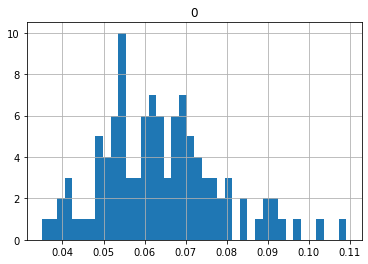

In [ ]:
ao_kurl = AbsoluteOrientation ()

ao_kurl.fit(emb_ru_kurl, emb_en, pairs_list[['ru_kurl', 'en']])

emb_ru_kurl_au = emb_ru_kurl.copy()
emb_ru_kurl_au['word_embedding'] = ao_kurl.predict(emb_ru_kurl_au)

emb_ru_kurl_short, emb_en_short =\
emb_ru_kurl.loc[pairs_list[['ru_kurl', 'en']].values[:,0]], \
emb_en.loc[pairs_list[['ru_kurl', 'en']].values[:,1]]

mcd = paired_cosine_distances(emb_ru_kurl_short.word_embedding.tolist(), \
                                      emb_en_short.word_embedding.tolist())
print(f'mean cosine distance before alignment: {np.mean(mcd)}')
emb_ru_kurl_au_short, emb_en_short =\
emb_ru_kurl_au.loc[pairs_list[['ru_kurl', 'en']].values[:,0]], \
emb_en.loc[pairs_list[['ru_kurl', 'en']].values[:,1]]

mcd = paired_cosine_distances(emb_ru_kurl_au_short.word_embedding.tolist(), \
                                      emb_en_short.word_embedding.tolist())
print(f'mean cosine distance after alignment: {np.mean(mcd)}')
pd.DataFrame(mcd).hist(bins = 40)
ind_min = np.argmin(mcd)
print(f'\nmin cosine distance: {min(mcd)}')

token = emb_ru_kurl_au_short.iloc[ind_min]['token']
print(f'token: {token}')
print(emb_en_short.iloc[ind_min]['txt'])
print(emb_ru_kurl_au_short.iloc[ind_min]['txt'])


ind_max = np.argmax(mcd)
print(emb_en_short.iloc[ind_max]['txt'])
print(f'\nmax cosine distance: {max(mcd)}')
token = emb_ru_kurl_au_short.iloc[ind_max]['token']
print(f'token: {token}')
print(emb_ru_kurl_au_short.iloc[ind_max]['txt'])

## sarn

True
mean cosine distance before alignment: 1.0066969394683838
mean cosine distance after alignment: 0.06062065401264802

min cosine distance: 0.033270643927531526
token: белый
A dusty white business envelope lay beside it.
Рядом с ней лежал пыльный белый конверт.
She pushed the doors
open, revealing The King's bedroom, a room which was all black and
white-black walls, white shag rug, black drapes over the windows, white
trim on the black bedspread-except for the ceiling, which was painted
midnight blue with a thousand twinkly electric stars.

max cosine distance: 0.09856285776233117
token: белой
Она распахнула двери, ведущие в спальню Короля — черно-белую комнату с черными стенами, белым ковром, черными шторами на окнах и черным покрывалом с белой каймой на постели, — где лишь потолок был выкрашен в темно-голубой цвет ночного неба с тысячами сверкающих электрических звездочек.


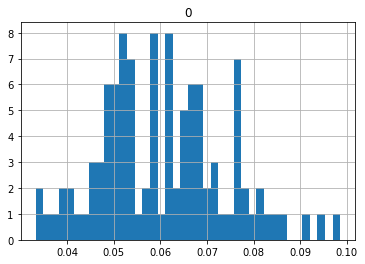

In [ ]:
ao_sarn = AbsoluteOrientation ()
ao_sarn.fit(emb_ru_sarn, emb_en, pairs_list[['ru_sarn', 'en']])

emb_ru_sarn_au = emb_ru_sarn.copy()

emb_ru_sarn_au['word_embedding'] = ao_sarn.predict(emb_ru_sarn_au)

emb_ru_sarn_short, emb_en_short =\
emb_ru_sarn.loc[pairs_list[['ru_sarn', 'en']].values[:,0]], \
emb_en.loc[pairs_list[['ru_sarn', 'en']].values[:,1]]

mcd = np.mean(paired_cosine_distances(emb_ru_sarn_short.word_embedding.tolist(), \
                                      emb_en_short.word_embedding.tolist()))

print(f'mean cosine distance before alignment: {mcd}')

emb_ru_sarn_au_short, emb_en_short =\
emb_ru_sarn_au.loc[pairs_list[['ru_sarn', 'en']].values[:,0]], \
emb_en.loc[pairs_list[['ru_sarn', 'en']].values[:,1]]

mcd = paired_cosine_distances(emb_ru_sarn_au_short.word_embedding.tolist(), \
                                      emb_en_short.word_embedding.tolist())

print(f'mean cosine distance after alignment: {np.mean(mcd)}')
pd.DataFrame(mcd).hist(bins = 40)
ind_min = np.argmin(mcd)
print(f'\nmin cosine distance: {min(mcd)}')

token = emb_ru_sarn_au_short.iloc[ind_min]['token']
print(f'token: {token}')
print(emb_en_short.iloc[ind_min]['txt'])
print(emb_ru_sarn_au_short.iloc[ind_min]['txt'])


ind_max = np.argmax(mcd)
print(emb_en_short.iloc[ind_max]['txt'])
print(f'\nmax cosine distance: {max(mcd)}')
token = emb_ru_sarn_au_short.iloc[ind_max]['token']
print(f'token: {token}')
print(emb_ru_sarn_au_short.iloc[ind_max]['txt'])

In [ ]:
f_plot(pairs_list, [emb_ru_sarn_au_short, emb_ru_kurl_au_short], emb_en_short, n_neighbors = 13, min_dist = 0)

FCNNs

Get optial transformation: emb_list_ru -> emb_list_en to minimaze angles

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
device

device(type='cpu')

In [ ]:
class CustomDataset:
  def __init__(self, emb_source, emb_target):
    self.emb_source = emb_source
    self.emb_source_shape = emb_source.shape
    self.emb_target = emb_target
    self.emb_target_shape = emb_target.shape
    assert self.emb_source_shape == self.emb_target_shape
  def __len__(self):
    return self.emb_source_shape[0]
  def __getitem__(self, idx):
    source = self.emb_source[idx]
    target = self.emb_target[idx]
    return torch.tensor(source, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [ ]:

# pairs_list = pd.read_pickle('./pairs_list.pkl')

# emb_ru_sarn_short, emb_en_short = emb_ru.loc[pairs_list.values[:,0]], emb_en.loc[pairs_list.values[:,1]]
print(emb_ru_kurl_short.shape, emb_en_short.shape)
train_dataset = CustomDataset(emb_ru_kurl_short['word_embedding'].values, emb_en_short['word_embedding'].values)

(107, 5) (107, 8)


In [ ]:
class FF(nn.Module):
  def __init__(self, input_size = 768, hidden_size = 768, ouput_size = 768):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.ouput_size = ouput_size
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_size, ouput_size)
  def forward(self, x):
    out = self.linear1(x)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.linear2(out)
    return out

def mean_cosine_dist(output, target):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    return torch.mean(1 - cos(output, target))

model = FF()
model = model.to(device)
criterion = mean_cosine_dist
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
BATCH_SIZE = 5
from torch.utils.data.dataset import random_split

num_train = int(len(train_dataset) * 0.75)
num_test = len(train_dataset) - num_train

train_, valid_ = random_split(train_dataset, [num_train, num_test])

train_dataloader = DataLoader(train_, batch_size = BATCH_SIZE, shuffle = True, )
valid_dataloader = DataLoader(valid_, batch_size=BATCH_SIZE,)

In [ ]:
def train(dataloader, optimizer=optimizer, criterion=criterion):
    model.train()
    total_loss = 0
    for idx, batch in enumerate(dataloader):
      batch_source, batch_taget = batch
      batch_source, batch_taget = batch_source.to(device), batch_taget.to(device)
      optimizer.zero_grad()
      output = model(batch_source)
      loss = criterion(output, batch_taget)
      loss.backward()
      total_loss += loss
      optimizer.step()
      optimizer.zero_grad()
    mean_loss = total_loss/(idx + 1)
    return mean_loss.to('cpu')

def evaluate(dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
      for idx, batch in enumerate(dataloader):
        batch_source, batch_taget = batch
        batch_source, batch_taget = batch_source.to(device), batch_taget.to(device)
        output = model(batch_source)
        loss = criterion(output, batch_taget)
        total_loss += loss
    mean_loss = total_loss/(idx + 1)
    return mean_loss.to('cpu')

In [ ]:
EPOCHS = 100
max_verbose = 10

for epoch in range(0, EPOCHS):
    mean_loss_train = train(train_dataloader)
    mean_loss_valid = evaluate(valid_dataloader)
    if epoch%(EPOCHS//max_verbose) == 0:
      print(f'epoch:{epoch + 1}, mean_loss_train: {mean_loss_train:.8f}, mean_loss_valid: {mean_loss_valid:.8f}')

epoch:1, mean_loss_train: 0.46948063, mean_loss_valid: 0.34295622
epoch:11, mean_loss_train: 0.07817266, mean_loss_valid: 0.14154048
epoch:21, mean_loss_train: 0.04849036, mean_loss_valid: 0.14115743
epoch:31, mean_loss_train: 0.04032562, mean_loss_valid: 0.13641703
epoch:41, mean_loss_train: 0.03354115, mean_loss_valid: 0.13578583
epoch:51, mean_loss_train: 0.03253742, mean_loss_valid: 0.13296808
epoch:61, mean_loss_train: 0.02904495, mean_loss_valid: 0.13537002
epoch:71, mean_loss_train: 0.02833111, mean_loss_valid: 0.13449965
epoch:81, mean_loss_train: 0.02690146, mean_loss_valid: 0.13555478
epoch:91, mean_loss_train: 0.02618607, mean_loss_valid: 0.13308515


In [ ]:
emb_ru_kurl_short_nn = emb_ru_kurl_short.copy()
with torch.no_grad():
  model = model.to('cpu')
  emb_ru_kurl_short_nn['word_embedding'] = \
    model(torch.tensor(np.stack(emb_ru_kurl_short_nn['word_embedding']), dtype=torch.float32)).detach().numpy().tolist()

In [ ]:
%%time
# emb_ru_nn_short, emb_en_short = emb_ru_nn.loc[np.array(pairs_list)[:,0]], emb_en.loc[np.array(pairs_list)[:,1]]

print(np.mean(paired_cosine_distances(emb_ru_kurl_short_nn.word_embedding.tolist(), \
                                      emb_en_short.word_embedding.tolist())))


0.03831340507415718
CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 10.8 ms
